# Fasttext Supervised learning example 

This notebook is inspired by the [Supervised Learning fastText tutorial](https://github.com/facebookresearch/fastText/blob/master/tutorials/supervised-learning.md)

In [1]:
import fastText as ft
from fastText import train_supervised
from string import punctuation
from nltk.corpus import stopwords
from itertools import islice
from os import path
import numpy as np
import matplotlib.pyplot as plt
from models import *
%matplotlib inline

In [2]:
def read_data(filename):
    """
    Read data 'line by line', using generators.
    Generators make it easier to process BIG text files.
    """
    with open(filename, 'r') as input:
        for line in input:
            yield line

In [4]:
def write_data(filename, data):
    """
    Write result to a file.
    
    :param result: the list to be written to the file
    """
    with open(filename, "a") as output:
        output.write('{}\n'.format(data))

In [5]:
def preprocess_(data):
    """
    Preprocess data, filtering out stopwords, punctuation and lowering 
    all splitted tokens.
    
    :param data: the string data to be processed
    """    
    # Pad punctuation with spaces on both sides
    for char in ['.', '"', ',', '(', ')', '!', '?', ';', ':']:
        data = data.replace(char, ' ' + char + ' ')
    sw = stopwords.words('english')
    splitted_chunks = data.split()
    lowered_chunks = (item.lower() for item in splitted_chunks)
    chunks_without_punctuation = (chunk for chunk in lowered_chunks if chunk not in punctuation)
    chunks_without_stopwords = (chunk for chunk in chunks_without_punctuation if chunk not in sw)
    return " ".join(list(chunks_without_stopwords))

In [6]:
def pipeline(input_filename, output_filename, limit=None):
    """
    Iterate over the rows and apply the text preprocessing.

    :param input_filename: name of the input filename
    :param output_filename: name of the output filename
    :param limit: get the first N rows
    """    
    open(output_filename, 'w').close()  # Hack to "reset" the output file
    for row in islice(read_data(input_filename), 0, limit):
        data = preprocess_(row)
        if data:
            write_data(output_filename, data)

In [7]:
def test_model(model, test_data):
    result = model.test(test_data)
    print('Precision@1:', result.precision)
    print('Recall@1:', result.recall)
    print('Number of examples:', result.nexamples)

In [8]:
def fastText_split(df, split, directory):
    train, dev, test = split_dataframe(df, split)
    fasttext_formatter(train, "temp_train.txt")
    pipeline("temp_train.txt", directory+"train.txt")
    fasttext_formatter(dev, "temp_dev.txt")
    pipeline("temp_dev.txt", directory+"dev.txt")
    fasttext_formatter(test, "temp_test.txt")
    pipeline("temp_test.txt", directory+"test.txt")
    

In [49]:
sender_df = preprocess("sender_data.csv")
sender_df["text"] = sender_df["content"].apply(preprocess_)
sender_splits = get_splits(sender_df)
fastText_split(sender_df, sender_splits, "fastText_data/sender/")
recipient_df = preprocess("recipient_data.csv")
recipient_df["text"] = recipient_df["content"].apply(preprocess_)
recipient_splits = get_splits(recipient_df)
fastText_split(recipient_df, recipient_splits, "fastText_data/recipient/")
pipeline("fastText_data/recipient_FairFrame.txt", "fastText_data/recipient/fairframe.txt")
pipeline("fastText_data/author_FairFrame.txt", "fastText_data/sender/fairframe.txt")

In [10]:
model = train_supervised("fastText_data/recipient/train.txt")
model.test("fastText_data/recipient/dev.txt")

(1720, 0.5447674418604651, 0.5447674418604651)

In [11]:


data_dir = path.join(path.dirname("__file__"), 'data')
enron_input = path.join(data_dir, 'recipient_data.txt')
fairframe_test = path.join(data_dir, 'fairframe.train') 


In [12]:
#pipeline(cooking_input, cooking_input_norm)

### Using fasttext

In [12]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [13]:
def results(N, p, r):
    return N, p, r
    

In [50]:
sender = {"train":"fastText_data/sender/train.txt",
          "dev":"fastText_data/sender/dev.txt",
          "test":"fastText_data/sender/test.txt",
          "fairframe":"fastText_data/sender/fairframe.txt"}
recipient = {"train":"fastText_data/recipient/train.txt", 
             "dev":"fastText_data/recipient/dev.txt",
             "test":"fastText_data/recipient/test.txt",
             "fairframe":"fastText_data/recipient/fairframe.txt"}

In [15]:

# Info to save the model
model_dir = path.join(path.dirname("__file__"), 'models')
gender_output = path.join(model_dir, 'gender_classification')

In [16]:
def get_F1(p, r):
    return(2.0/((p**-1)+(r**-1)))

In [17]:
def get_acc(model, df):
    
    pred = df.text.apply(lambda x: model.predict(x)[0][0][9].capitalize())
    return sum(pred==df.gender)/len(df)
%time get_acc(model, sender_df.iloc[sender_splits[1]])

CPU times: user 44.2 ms, sys: 2.1 ms, total: 46.3 ms
Wall time: 47.4 ms


0.58074935400516792

# Senders

(4, 4)

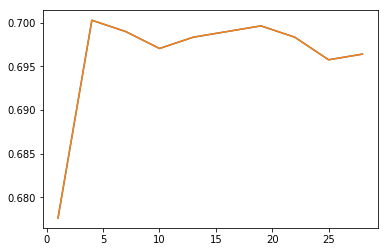

In [78]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = list(range(1,30, 3))
sender_val = sender_df.iloc[sender_splits[1]]
for count in param_range:
    model = train_supervised(input=sender["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-1, #tuned minimal improvements
                             ws = 7, #tuned 
                             wordNgrams=count, #tuned 
                             verbose=1, #tuned minimal improvements
                             minCount=4, 
                             dim=200)
    N,p,r =  results(*model.test(sender["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, sender_val))




plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]

(-1, -1)

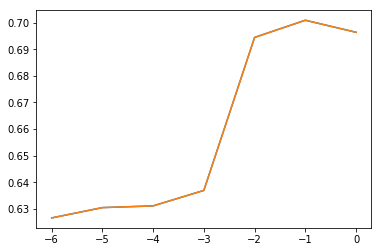

In [79]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = np.arange(-6,1)
sender_val = sender_df.iloc[sender_splits[1]]
for rate in 10.0**param_range:
    model = train_supervised(input=sender["train"], 
                             epoch=50, #tuned 
                             lr=rate, #tuned minimal improvements
                             ws = 7, #tuned 
                             wordNgrams=4, #tuned 
                             verbose=1, #tuned minimal improvements
                             minCount=4, 
                             dim=200)
    N,p,r =  results(*model.test(sender["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, sender_val))


plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]

In [51]:
#best model for sender
sender_test = sender_df.iloc[sender_splits[2]]
sender_val = sender_df.iloc[sender_splits[1]]
sender_model = train_supervised(input=sender["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-1, #tuned minimal improvements
                             ws = 7, #tuned 
                             wordNgrams=4, #tuned 
                             verbose=1, #tuned minimal improvements
                             minCount=4, 
                             dim=200)
N,p,r =  results(*model.test(sender["test"]))
print(get_acc(sender_model, sender_test), get_acc(sender_model, sender_val))
#insert model tested on fair frame here

0.69163706813 0.691860465116


# Recipients

3

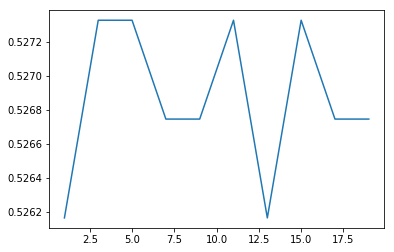

In [81]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = list(range(1,20, 2))
recipient_val = recipient_df.iloc[sender_splits[1]]
for count in param_range:
    model = train_supervised(input=recipient["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-2, #tuned minimal improvements
                             ws = count, #tuned 
                             wordNgrams=15, #tuned 
                             verbose=3, #tuned minimal improvements
                             minCount=1, 
                             dim=200)
    N,p,r =  results(*model.test(recipient["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, recipient_val))




plt.plot(param_range,f1)
param_range[np.argmax(f1)]

-2

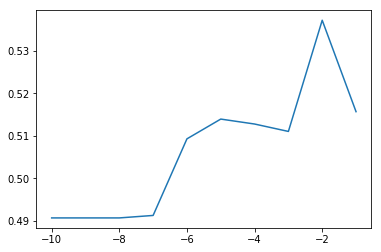

In [82]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = np.arange(-10,0)
recipient_val = recipient_df.iloc[sender_splits[1]]
for rate in 10.0**param_range:
    model = train_supervised(input=recipient["train"], 
                             epoch=50, #tuned 
                             lr=rate, #tuned minimal improvements
                             ws = 2, #tuned 
                             wordNgrams=3, #tuned 
                             verbose=5, #tuned minimal improvements
                             minCount=1, 
                             dim=200)
    N,p,r =  results(*model.test(recipient["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, recipient_val))

plt.plot(param_range,f1)
param_range[np.argmax(f1)]

In [52]:
#Best model for recipient
recipient_test = recipient_df.iloc[sender_splits[2]]
recipient_val = recipient_df.iloc[sender_splits[1]]
recipient_model = train_supervised(input=recipient["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-2, #tuned minimal improvements
                             ws = 3, #tuned 
                             wordNgrams=15, #tuned 
                             verbose=3, #tuned minimal improvements
                             minCount=1, 
                             dim=200)

print(get_acc(recipient_model, recipient_test), get_acc(recipient_model, recipient_val))
#insert model tested on fair frame here

0.585082337746 0.571705426357


# Vizulations and Examples

In [21]:


def get_prob_df(df, model):
    label = df.gender
    label.name = "true_label"
    pred_label = df.text.apply(lambda x: model.predict(x)[0][0][9].capitalize())
    pred_label.name = "predicted_label"
    prob_label = df.text.apply(lambda x: model.predict(x)[1][0])
    prob_label.name = "prob_of_predicted_label"
    prob_label = prob_label.apply(lambda x: x**(x<1))
    prob_F = abs(1*(pred_label == "M")-prob_label)
    prob_F.name = "prob of F"
    prob_M = abs(1*(pred_label == "F")-prob_label)
    prob_M.name = "prob of M"
    data = [label, pred_label, prob_label, prob_F, prob_M]
    return pd.concat(data, axis=1, keys=[s.name for s in data])

In [22]:
sender_test_pred = get_prob_df(sender_test, sender_model)
recipient_test_pred = get_prob_df(recipient_test, recipient_model)

In [58]:
def get_prob_df_from_txt(filename, model):
    f = open(filename, "r")
    lines =  f.read().split("\n")[:-1]
    f.close()
    labels = [line[9].capitalize() for line in lines]
    labels = pd.Series(labels, name="true_label")
    pred_label = [model.predict(x)[0][0][9].capitalize() for x in lines]
    pred_label = pd.Series(pred_label, name="predicted_label")
    prob_label = [model.predict(x)[1][0]  for x in lines]
    prob_label = pd.Series(prob_label, name="prob_of_predicted_label")
    prob_label = prob_label.apply(lambda x: x**(x<1))
    prob_F = abs(1*(pred_label == "M")-prob_label)
    prob_F.name = "prob of F"
    prob_M = abs(1*(pred_label == "F")-prob_label)
    prob_M.name = "prob of M"
    data = [labels, pred_label, prob_label, prob_F, prob_M]
    return pd.concat(data, axis=1, keys=[s.name for s in data])


In [60]:
sender_fairframe_df = get_prob_df_from_txt(sender["fairframe"], sender_model)
recipient_fairframe_df = get_prob_df_from_txt(recipient["fairframe"], recipient_model)

In [23]:
from sklearn import linear_model, svm, metrics
def rocplot(truth, pred, name):
    
    fpr, tpr, thresholds = metrics.roc_curve(truth, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    if roc_auc < 0.5:
        fpr, tpr, thresholds = metrics.roc_curve(truth, -1 * pred)
        roc_auc = metrics.auc(fpr, tpr)
        
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color = c, label = name + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right")

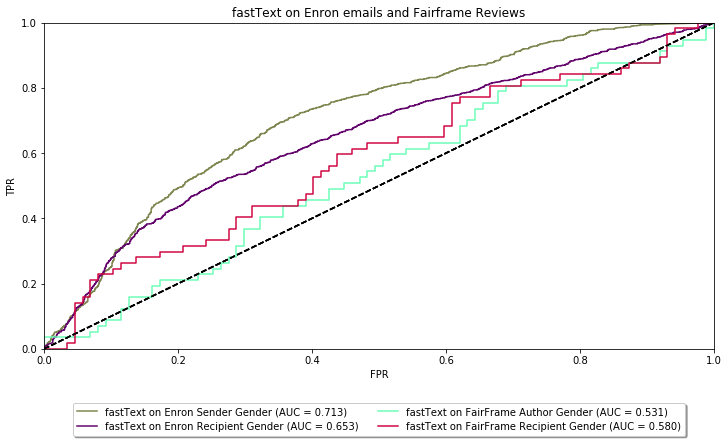

In [65]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
rocplot(1*(sender_test_pred.true_label == "F"),
        sender_test_pred["prob of F"],
        "fastText on Enron Sender Gender")
rocplot(1*(recipient_test_pred.true_label == "F"),
        recipient_test_pred["prob of F"],
        "fastText on Enron Recipient Gender")
rocplot(1*(sender_fairframe_df.true_label == "F"),
        sender_fairframe_df["prob of F"],
        "fastText on FairFrame Author Gender")
rocplot(1*(recipient_fairframe_df.true_label == "F"),
        recipient_fairframe_df["prob of F"],
        "fastText on FairFrame Recipient Gender")
plt.title("fastText on Enron emails and Fairframe Reviews")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
lgd = ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True,
                shadow = True, ncol = 2, prop = {'size':10})
plt.savefig("ROC.png")

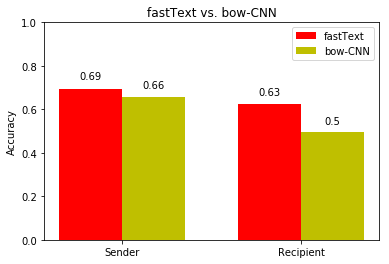

In [25]:
#based off of matplotlib demo
#https://matplotlib.org/examples/api/barchart_demo.html

N = 2
fastText_accs = (get_acc(sender_model, sender_test), get_acc(recipient_model, recipient_test))
CNN_accs =(0.6551501453019051, 0.4963673350770125) # these values were taken from the bowCNN notebook
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, fastText_accs, width, color='r')


rects2 = ax.bar(ind + width, CNN_accs, width, color='y')
plt.ylim([0.0, 1.0])
# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('fastText vs. bow-CNN')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Sender', 'Recipient'))

ax.legend((rects1[0], rects2[0]), ('fastText', 'bow-CNN'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%s' % round(height,2),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
#uncomment to save figure
#plt.savefig("bars_comparison.png")

# Example Sentences

In [26]:
import random
def worst_example_finder(df, pred_df, num_examples = 10, p =0.7):
    choose_from = pred_df[:][pred_df.true_label != pred_df.predicted_label]
    emails = df.content[pred_df.true_label != pred_df.predicted_label]
    chosen = emails[choose_from["prob_of_predicted_label"] >= p]
    probs = choose_from["prob_of_predicted_label"][choose_from["prob_of_predicted_label"] >= p]
    labels = choose_from["predicted_label"][choose_from["prob_of_predicted_label"] >= p]
    for i in range(num_examples):
        rando = int(random.randint(0,len(chosen)))
        print(chosen.iloc[rando]+" \n (With probability %s as %s) \n" %(probs.iloc[rando], labels.iloc[rando]) )
    

In [27]:
worst_example_finder(sender_test, sender_test_pred, 5, .9)

Shirley,  Voucher # dummynumber  for  $359.78   Vince 
 (With probability 0.994631409645 as M) 

you're a goddess.  thank you. 
 (With probability 0.997220814228 as M) 

Should we wait on this, given the possibilities we discussed earlier today.  Michelle 
 (With probability 0.927020311356 as F) 

I will be out dummydate on a customer trip (San Antonio with Aquila).  I will be on vacation in dummydate from dummydate  D 
 (With probability 0.991761863232 as M) 

Grant,   Did Li Xiao refer Alex  to us?  Vince 
 (With probability 0.976870417595 as M) 



In [ ]:
def best_example_finder(df, pred_df, num_examples = 10, p = 0.7):
    choose_from = pred_df[:][pred_df.true_label == pred_df.predicted_label]
    emails = df.content[pred_df.true_label == pred_df.predicted_label]
    chosen = emails[choose_from["prob_of_predicted_label"] >= p]
    probs = choose_from["prob_of_predicted_label"][choose_from["prob_of_predicted_label"] >= p]
    labels = choose_from["predicted_label"][choose_from["prob_of_predicted_label"] >= p]
    for i in range(num_examples):
        rando = int(random.randint(0,len(chosen)))
        print(chosen.iloc[rando]+" \n (With probability %s as %s) \n" %(probs.iloc[rando], labels.iloc[rando]) )

In [ ]:
best_example_finder(sender_test, sender_test_pred, 5, 1)

### Not normalized input

### Normalized input

### Load existing test

### Predictions